In [71]:
# Use this cell to regroup all your imports
%load_ext autoreload
%autoreload 2
from deep_currents.model import Model
from sklearn import set_config; set_config(display='diagram')
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

## Train data

In [72]:
m = Model()

In [73]:
m.open_data()

## Test data

# Prepare data

## Build pipeline for preproc data

This pipeline is important to adjust the data to enter in the DL model.

We are applying two corrections:
- KNNImputer: to impute value when we have missing data. It will get the closest value to complete
- Standardcale: to use ML and DL models, we have to rescale all variables to the same scale. I choose Standard sclae, but it will depends on the hist distribuition of the variations (normal distribution and outliers)

(array([ 48., 144., 106.,  72.,  59.,  56.,  67.,  49.,  27.,  20.]),
 array([294.6000061 , 294.73620605, 294.87240601, 295.00860596,
        295.14480591, 295.28100586, 295.41720581, 295.55340576,
        295.68960571, 295.82580566, 295.96200562]),
 <BarContainer object of 10 artists>)

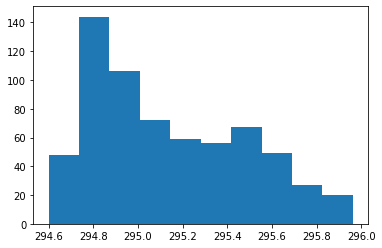

In [74]:
plt.hist(m.X[0][17:-1])

(array([3., 1., 0., 0., 0., 1., 1., 2., 3., 5.]),
 array([0.7934 , 0.80665, 0.8199 , 0.83315, 0.8464 , 0.85965, 0.8729 ,
        0.88615, 0.8994 , 0.91265, 0.9259 ]),
 <BarContainer object of 10 artists>)

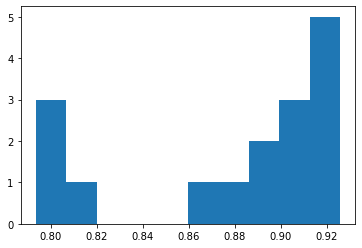

In [75]:
plt.hist(m.X[0][0:16])

In [76]:
m.preproc()

StandardScaler()

## Preproc data

Fit the data ⬇️

In [77]:
m.preproc_fit()

# Machine Learning

In [78]:
m.basic_ml(model='ridge')

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [79]:
m.validation_split(test_size=0.3)

In [80]:
m.score_baseline()

MSE = 16.276942909686927


2.9770894782486086


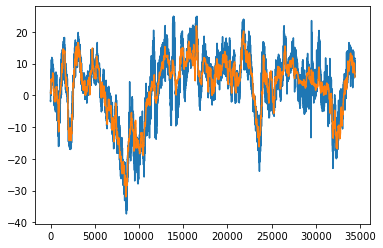

In [81]:
m.predict_baseline()

# Deep Learning

## Preproc data

In [82]:
m.preproc_transform()

## Initialize model

See the shape of your data and try insert the number of columns in the input_dim value

In [13]:
m.define_model()


learning rate: 0.001
Loss = msle
Metric = mae
Opt = adam
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               80040     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
________________________________________________________________

2021-08-06 13:15:29.962048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize modal and show its summary

## Fit model to your data

In [14]:
m.validation_split(test_size=0.3, deep=True)

In [15]:
m.learning_rate()

In [16]:
m.model_fit()

Early stop with patience 10
Batch size 32
Epoch = 100
Validation Split = 30%
Epoch 1/300


2021-08-06 13:15:30.451912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-06 13:15:30.452669: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


1054/1054 [==============================] - 4s 3ms/step - loss: 3.0940 - mae: 8.6523 - val_loss: 3.0514 - val_mae: 8.5402
Epoch 2/300
1054/1054 [==============================] - 2s 2ms/step - loss: 3.0467 - mae: 8.6117 - val_loss: 3.0514 - val_mae: 8.5402
Epoch 3/300
1054/1054 [==============================] - 2s 2ms/step - loss: 3.0678 - mae: 8.6295 - val_loss: 3.0514 - val_mae: 8.5402
Epoch 4/300
  55/1054 [>.............................] - ETA: 1s - loss: 3.1040 - mae: 8.6386

KeyboardInterrupt: 

## Evaluate the model

In [ ]:
m.plot_history()

In [ ]:
m.model_evaluate()

## Predict the data

In [ ]:
m.predict_deep()

# Time Series Analisys

### Split train test data - the data is already Standard Scaled


In [90]:
len_ = int(0.8*m.X_preproc.shape[0])
X_train = m.X_preproc[:len_]
X_test = m.X_preproc[len_:]
y_train = m.y[:len_]
y_test = m.y[len_:]

In [98]:
np.expand_dims(y_train, 1).shape

(27525, 1)

In [132]:
df_train = pd.DataFrame(np.concatenate((X_train, np.expand_dims(y_train, 1)), axis=1))
df_train['u_vel'] = df_train[666]
df_train = df_train.drop(columns=666)
df_test = pd.DataFrame(np.concatenate((X_test, np.expand_dims(y_test, 1)), axis=1))
df_test['u_vel'] = df_test[666]
df_test = df_test.drop(columns=666)

In [133]:
print("train shape: {}, test shape: {}".format(df_train.shape,df_test.shape))

train shape: (27525, 667), test shape: (6882, 667)


## Create (X,y)

In [135]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

def compute_means(X, df_mean):
    '''utils'''
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""
    
    # Trick to save time during the recursive calls
    if df_mean is None:
        df_mean = df.drop(columns='u_vel').mean()
        
    df_subsample = subsample_sequence(df, length).copy()
    
    # Let's drop any row without a target! We need targets to fit our model
    df_subsample.dropna(how='any', subset=['u_vel'], inplace=True)
    
    # Create y_sample
    if df_subsample.shape[0] == 0: # Case if there is no targets at all remaining
        return split_subsample_sequence(df, length, df_mean) # Redraw by recursive call until it's not the case anymore
    y_sample = df_subsample[['u_vel']]
    
    # Create X_sample
    X_sample = df_subsample.drop(columns='u_vel')
    if X_sample.isna().sum().sum() !=0:  # Case X_sample has some NaNs
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths):
    '''Return a dataset (X, y)'''
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    return X, y

In [136]:
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [137]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

## Padding sequences with differences in lenght

In [138]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train, value=-1000., dtype=float, padding='post', maxlen=30)
y_train_pad = pad_sequences(y_train, value=-1000., dtype=float, padding='post', maxlen=30)

X_test_pad = pad_sequences(X_test, value=-1000., dtype=float, padding='post', maxlen=30)
y_test_pad = pad_sequences(y_test, value=-1000., dtype=float, padding='post', maxlen=30)

X_train_pad.shape

(1000, 30, 666)

## Validation baseline with mean

In [139]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean([_ for elt in y_train for _ in elt])
bench_res = np.mean(np.abs([_-y_pred for elt in y_test for _ in elt]))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 6.1454


## Deep Learning Model

In [147]:
model = models.Sequential()

[autoreload of six failed: Traceback (most recent call last):
  File "/srv/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/srv/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/srv/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/srv/conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/srv/conda/lib/python3.9/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'filter'
]


In [148]:
model.add(layers.Masking(mask_value=-1000., input_shape=(30,666)))

In [149]:
model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))

TypeError: an integer is required (got type _NoValueType)

In [142]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

def init_model():
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(30,666)))
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.add(layers.SimpleRNN(10, return_sequences=True, input_shape=((4, 3)))) 
    model.add(layers.SimpleRNN(3, return_sequences=False))
    model.add(Dense(1, activation='relu'))

    model_stacked.summary()
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae'])
    
    return model

init_model().summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=0)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [ ]:
res = model.evaluate(X_test_pad, y_test_pad, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}, or {res[1]/bench_res:.2f} times the benchmark')

In [ ]:
plt.figure(figsize=(17,3))
for id_plot, id_seq in enumerate(np.random.randint(low=0,high=len(X_test),size=5)):
    plt.subplot(1, 5, id_plot+1)
    plt.plot(y_test[id_seq], label='truth')
    plt.plot(model.predict(X_test_pad)[id_seq], label='pred')
    plt.ylim(ymin=0)
plt.legend();

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(df_train["Sales"])[1])